<a href="https://colab.research.google.com/github/deshm084/Multivariate-Time-Series-Predictor/blob/main/MultivariateTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3638703951.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2018-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data Loaded: 1460 days. Features: Close Price, MA50
Input Shape: (1120, 60, 2)

Training Model...
Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.1222
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0054
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0041
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0042
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0039
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0034
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0034
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0031
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0026
Epoch 10/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0026
Epoch 11/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0022
Epoch 12/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0025
Epoch 13/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0027
Epoch 14/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 1

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.12/dist-packages/matplotlib/pyplot.py'>

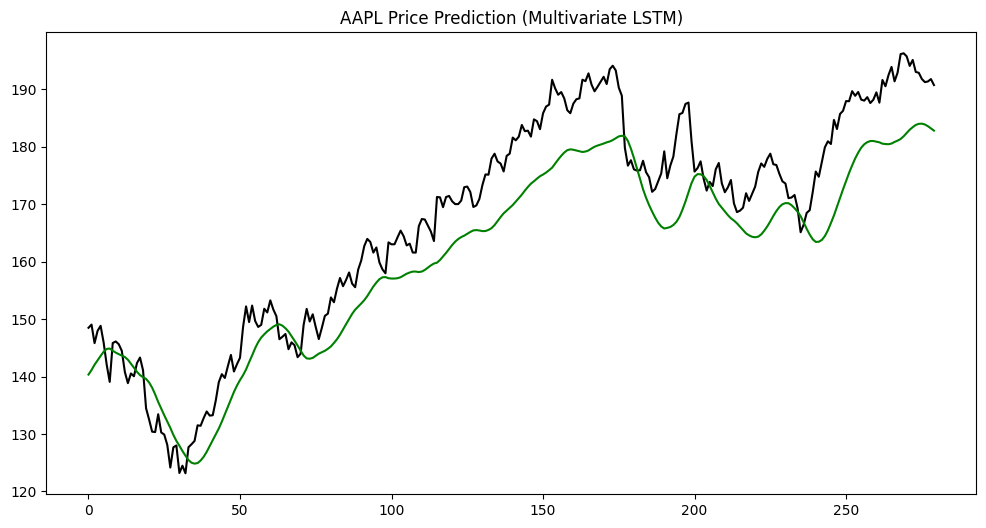

In [ ]:
"""
Project: Multivariate Stock Price Predictor (LSTM)
Author: Sanskruti
Description: A Deep Learning model that predicts stock prices using historical data
             and technical indicators (Moving Averages).
"""

# --- 1. Setup ---
# !pip install yfinance tensorflow numpy pandas scikit-learn matplotlib

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- 2. Data Loading & Feature Engineering ---
print("Downloading Data...")
# We fetch data for Apple (AAPL)
df = yf.download('AAPL', start='2018-01-01', end='2024-01-01')

# Feature Engineering: Add 50-day Moving Average
df['MA50'] = df['Close'].rolling(window=50).mean()

# Drop the first 50 rows (because MA50 is NaN for them)
df.dropna(inplace=True)

# Select features: Close Price AND Moving Average
# We use .values to convert to numpy array
data = df[['Close', 'MA50']].values

print(f"Data Loaded: {len(data)} days. Features: Close Price, MA50")

# --- 3. Scaling (Normalization) ---
# LSTMs work best with data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create a separate scaler just for 'Close' price so we can inverse_transform predictions later easily
price_scaler = MinMaxScaler(feature_range=(0, 1))
price_scaler.fit(df[['Close']])

# --- 4. Create Sequences (The Sliding Window) ---
def create_sequences(data, days_lookback=60):
    X = []
    y = []
    for i in range(days_lookback, len(data)):
        # Input: The last 60 days of BOTH Price and MA50
        X.append(data[i-days_lookback:i])
        # Target: The 'Close' price of the NEXT day (Column 0)
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOKBACK = 60
X, y = create_sequences(scaled_data, LOOKBACK)

# Split Train/Test (80/20 split) - STRICTLY CHRONOLOGICAL
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Input Shape: {X_train.shape}")
# Shape should be (Samples, 60, 2) -> The '2' is our two features!

# --- 5. Build LSTM Model ---
model = Sequential()

# Layer 1
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 2)))
model.add(Dropout(0.2))

# Layer 2
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# --- 6. Train ---
print("\nTraining Model...")
model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

# --- 7. Evaluate & Plot ---
predictions_scaled = model.predict(X_test)

# Convert scaled predictions back to dollars
predictions = price_scaler.inverse_transform(predictions_scaled)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, color='black', label='Actual Price')
plt.plot(predictions, color='green', label='Predicted Price')
plt.title('AAPL Price Prediction (Multivariate LSTM)')
plt